17.18 De-leveraging

In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [2]:
np.random.seed(1)

gamma = 6
T = 15
n = 10
mu = 20 * np.random.randn(n)
S = np.random.randn(n, n)
Sigma = S.T @ S + np.eye(n) * 0.15
Linit = 9.5
Lnew = 5
kappa = np.random.rand(n) * 10
Lambda = np.random.rand(n) * 20

In [7]:
x = cp.Variable(n)
objective = cp.Maximize(mu @ x - gamma * cp.quad_form(x, Sigma))
constraints = [cp.norm(x, 1) <= Linit]
prob = cp.Problem(objective, constraints)
result = prob.solve()
x0 = x.value
x = cp.Variable(n)
objective = cp.Maximize(mu @ x - gamma * cp.quad_form(x, Sigma))
constraints = [cp.norm(x, 1) <= Lnew]
prob = cp.Problem(objective, constraints)
result = prob.solve()
xT = x.value

In [23]:
X = cp.Variable((T+1, n))
objective = cp.Maximize(
    cp.sum(X[1:] @ mu) 
    - cp.sum([gamma * cp.quad_form(xt, Sigma) for xt in X[1:]])
    -  cp.sum(cp.abs(X[1:] - X[:-1]) @ kappa)
    -  cp.sum(cp.square(X[1:] - X[:-1]) @ Lambda)
)
constraints = [
    X[0] == x0,
    X[-1] == xT,
    cp.norm(X[1:-1], 1, axis=1) <= Linit
]
prob = cp.Problem(objective, constraints)
result = prob.solve()
x_opt = X.value 
x_lp = np.vstack((np.tile(x0, (T, 1)), xT)) # does all the trade at the last possible period
x_lin = np.array([(1 - t / T) * x0 +t /  T * xT for t in range(T+1)]) # linear interpolation between x_0 and x_T

In [31]:
def J(X):
    return (
        np.sum(X[1:] @ mu) 
        - np.sum([gamma * xt.T @ Sigma @ xt for xt in X[1:]])
        -  np.sum(np.abs(X[1:] - X[:-1]) @ kappa)
        -  np.sum(np.square(X[1:] - X[:-1]) @ Lambda)
    )
print('optimal objective value:', J(x_opt))
print('last trade objective value:', J(x_lp))
print('linear interpolated objective value:', J(x_lin))
def adjusted_return(X):
    return X[1:] @ mu - np.array([gamma * xt.T @ Sigma @ xt for xt in X[1:]]) - np.abs(X[1:] - X[:-1]) @ kappa - np.square(X[1:] - X[:-1]) @ Lambda

optimal objective value: 1252.1526851095252
last trade objective value: 1249.5236388695182
linear interpolated objective value: 1224.304524301763


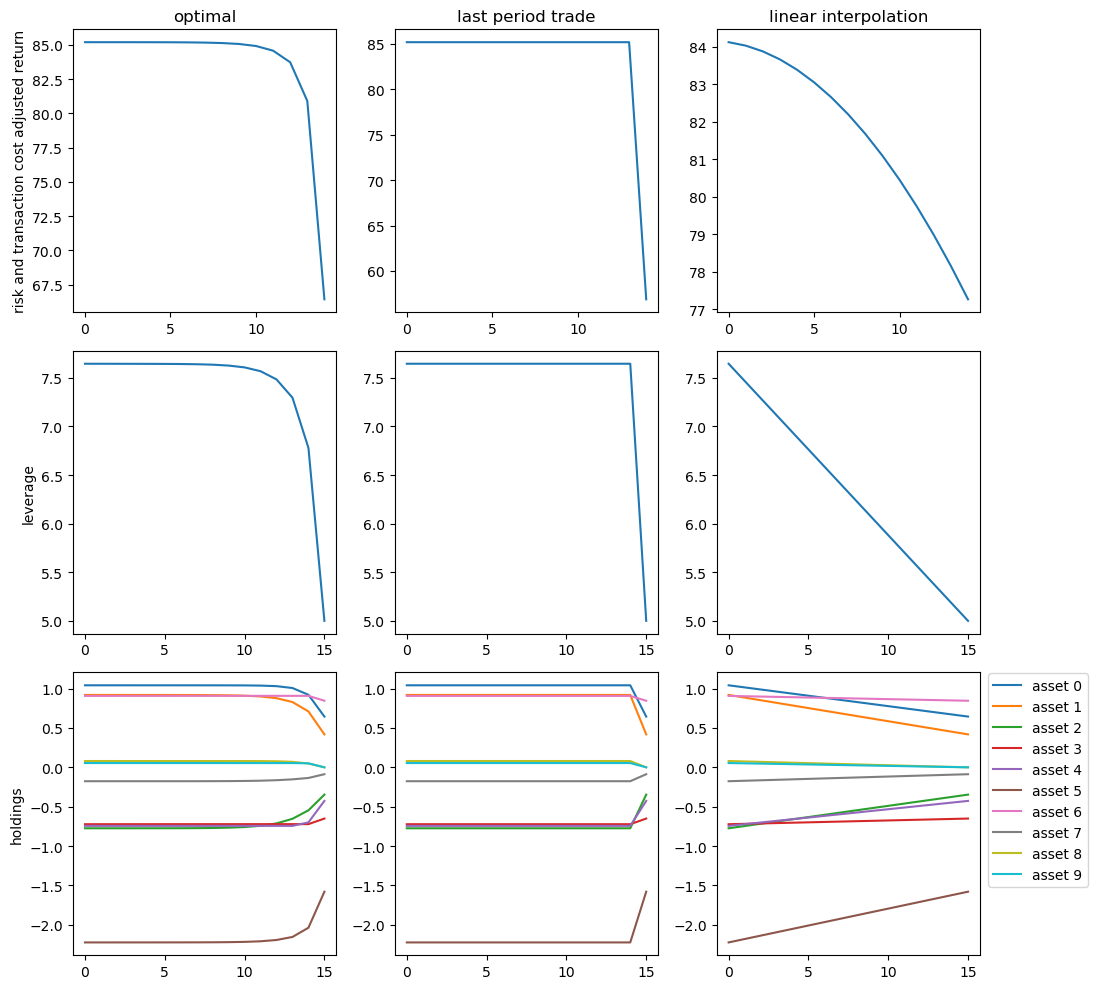

In [67]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

axs[0,0].plot(adjusted_return(x_opt))
axs[0,0].set_ylabel('risk and transaction cost adjusted return')
axs[0,0].set_title('optimal')
axs[0,1].plot(adjusted_return(x_lp))
axs[0,1].set_title('last period trade')
axs[0,2].plot(adjusted_return(x_lin))
axs[0,2].set_title('linear interpolation')
axs[1,0].plot(np.linalg.norm(x_opt, 1, axis=1))
axs[1,0].set_ylabel('leverage')
axs[1,1].plot(np.linalg.norm(x_lp, 1, axis=1))
axs[1,2].plot(np.linalg.norm(x_lin, 1, axis=1))
axs[2,0].plot(x_opt)
axs[2,0].set_ylabel('holdings')
axs[2,1].plot(x_lp)
axs[2,2].plot(x_lin, label=[f'asset {i}' for i in range(n)])
fig.legend(loc='lower right', bbox_to_anchor=(1.1, 0.1), ncol=1)
plt.tight_layout()
plt.show()